In [1]:
import os, sys
import sklearn
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import json
import pandas as pd
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from shutil import copyfile
import seaborn as sns

mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)
plt.rcParams["figure.figsize"] = (20,3)

np.random.seed(42)

In [2]:
dropout_quantity = 250

# Data loading

In [3]:
# Loading data from already prepared datasets
X_train, y_train, mean_features_train = (
    np.load('./data/X_train_shuffled_with_mean_model.npz'), 
    np.load('./data/y_train_shuffled_with_mean_model.npz'),
    np.load('./data/mean_features_train_shuffled_with_mean_model.npz'))
X_train, y_train, mean_features_train = X_train['arr_0'], y_train['arr_0'], mean_features_train['arr_0']

X_valid, y_valid, mean_features_valid = (
    np.load('./data/X_valid_shuffled_with_mean_model.npz'), 
    np.load('./data/y_valid_shuffled_with_mean_model.npz'), 
    np.load('./data/mean_features_valid_shuffled_with_mean_model.npz'))
X_valid, y_valid, mean_features_valid = X_valid['arr_0'], y_valid['arr_0'], mean_features_valid['arr_0']

X_test, y_test, mean_features_test = (
    np.load('./data/X_test_shuffled_with_mean_model.npz'), 
    np.load('./data/y_test_shuffled_with_mean_model.npz'),
    np.load('./data/mean_features_test_shuffled_with_mean_model.npz'))
X_test, y_test, mean_features_test = X_test['arr_0'], y_test['arr_0'], mean_features_test['arr_0']

In [4]:
y_test_org = np.copy(y_test)

# y categorization

In [5]:
one_ids = np.where(y_train >= 0.9)
zero_ids = np.where(y_train < 0.9)

y_train[one_ids[0], one_ids[1]] = 1
y_train[zero_ids[0], zero_ids[1]] = 0

ones, zeroes = len(one_ids[0]), len(zero_ids[0])
print(f'Positive %: {ones / (ones + zeroes)}')
print(f'Negative %: {1 - (ones / (ones + zeroes))}')

y_train = y_train.astype(np.int)

Positive %: 0.04737364845037358
Negative %: 0.9526263515496264


In [6]:
one_ids = np.where(y_valid >= 0.9)
zero_ids = np.where(y_valid < 0.9)

y_valid[one_ids[0], one_ids[1]] = 1
y_valid[zero_ids[0], zero_ids[1]] = 0

ones, zeroes = len(one_ids[0]), len(zero_ids[0])
print(f'Positive %: {ones / (ones + zeroes)}')
print(f'Negative %: {1 - (ones / (ones + zeroes))}')

y_valid = y_valid.astype(np.int)

Positive %: 0.062239534739068236
Negative %: 0.9377604652609317


In [7]:
one_ids = np.where(y_test >= 0.9)
zero_ids = np.where(y_test < 0.9)

y_test[one_ids[0], one_ids[1]] = 1
y_test[zero_ids[0], zero_ids[1]] = 0

ones, zeroes = len(one_ids[0]), len(zero_ids[0])
print(f'Positive %: {ones / (ones + zeroes)}')
print(f'Negative %: {1 - (ones / (ones + zeroes))}')

y_test = y_test.astype(np.int)

Positive %: 0.05826417435817886
Negative %: 0.9417358256418211


In [8]:
y_all = np.concatenate((y_train, y_valid, y_test))
temp = np.copy(y_all)
temp.shape

one_ids = np.where(temp >= 0.9)
zero_ids = np.where(temp < 0.9)

temp[one_ids[0], one_ids[1]] = 1
temp[zero_ids[0], zero_ids[1]] = 0

ones, zeroes = len(one_ids[0]), len(zero_ids[0])
print(f'Positive %: {ones / (ones + zeroes)}')
print(f'Negative %: {1 - (ones / (ones + zeroes))}')

unique, counts = np.unique(y_all, return_counts=True)
for val, qty in zip(unique, counts):
    print(f'Label {val}: {qty}')

Positive %: 0.05148319973085612
Negative %: 0.9485168002691439
Label 0: 603343
Label 1: 32748


# x/e model

In [9]:
class XEModel(sklearn.base.BaseEstimator):
    def __init__(self, dropout_qty: int, stock_qty: int, timestamp_pos: int):
        self.dropout_qty = dropout_qty
        self.stock_qty = stock_qty
        self.timestamp_pos = timestamp_pos
        self.sell_at_the_end = False

    def fit(self, X, y):
        return self

    def predict(self, batch: np.ndarray):
        results = []
        for i, X in enumerate(batch):
            stock_prices = X[:self.stock_qty]
            min_in_dropout = np.min(X[:-1])
            if self.sell_at_the_end:
                try:
                    if batch[i + 1, self.timestamp_pos, 0] < X[self.timestamp_pos, 0]:
                        results.append(1)
                        self.sell_at_the_end = False
                    else:
                        results.append(0)
                except IndexError as err:
                    print(err)
                    results.append(1)
                    self.sell_at_the_end = False
            else:
                if X[-1] > min_in_dropout:
                    results.append(1)
                else:
                    self.sell_at_the_end = True
                    results.append(0)
        return np.array(results)

# Predictions

In [10]:
_timestamp_pos = X_test.shape[1] - 1

In [11]:
mean_model = XEModel(250, 250, _timestamp_pos)
y_pred = mean_model.predict(X_test)
y_pred

array([1, 1, 1, ..., 1, 1, 1])

In [12]:
np.unique(y_pred, return_counts=True)

(array([0, 1]), array([24174, 40291]))

# Metrics

In [13]:
np.unique(y_test, return_counts=True)

(array([0, 1]), array([60709,  3756]))

In [14]:
tn, fp, fn, tp = sklearn.metrics.confusion_matrix(y_test, y_pred).ravel()
print((tn, fp, fn, tp))
print(sklearn.metrics.confusion_matrix(y_test, y_pred))

(23415, 37294, 759, 2997)
[[23415 37294]
 [  759  2997]]


total: 64465
[[0.36322035 0.57851547]
 [0.01177383 0.04649034]]


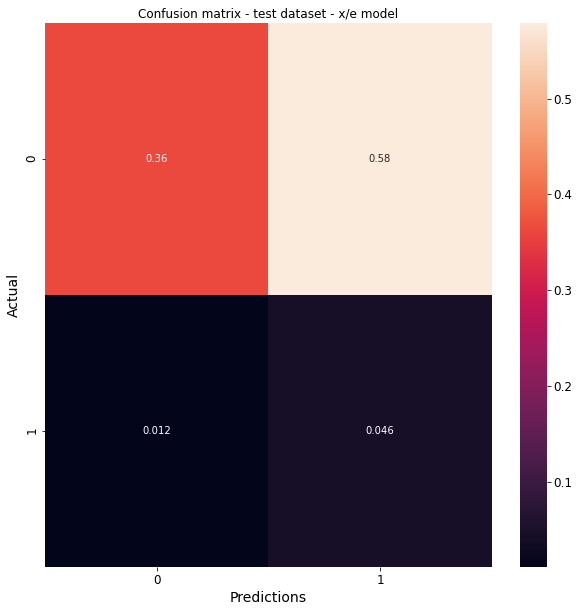

In [15]:
plt.figure(figsize=(10, 10))
cm = sklearn.metrics.confusion_matrix(y_test, y_pred)
print(f'total: {np.sum(cm)}')
cm = cm / np.sum(cm)
print(cm)
sns.heatmap(cm, annot=True)
plt.ylabel('Actual')
plt.xlabel('Predictions')
plt.title('Confusion matrix - test dataset - x/e model')
plt.show()

In [16]:
report = sklearn.metrics.classification_report(y_test, y_pred)
print('Test dataset')
print(report)

Test dataset
              precision    recall  f1-score   support

           0       0.97      0.39      0.55     60709
           1       0.07      0.80      0.14      3756

    accuracy                           0.41     64465
   macro avg       0.52      0.59      0.34     64465
weighted avg       0.92      0.41      0.53     64465



# Metric for whole dataset

In [17]:
X = np.concatenate((X_train, X_valid, X_test))
y = np.concatenate((y_train, y_valid, y_test))

y_pred_whole = mean_model.predict(X)
y_pred_whole

array([1, 1, 1, ..., 1, 1, 1])

total: 636091
[[0.29346744 0.65504936]
 [0.00994983 0.04153337]]


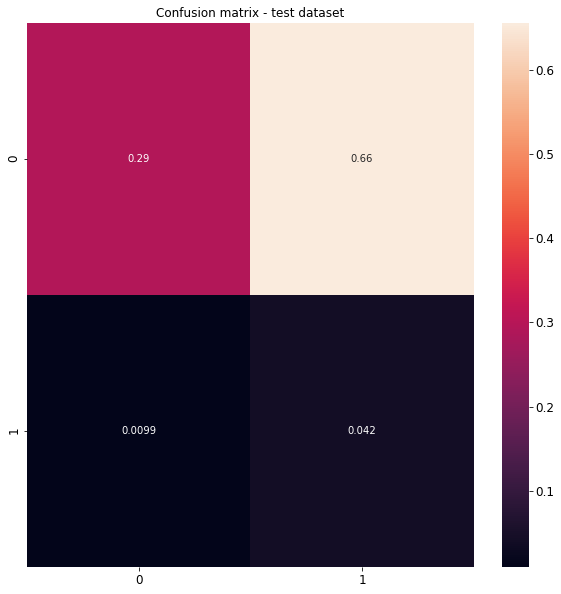

In [18]:
plt.figure(figsize=(10, 10))
cm = sklearn.metrics.confusion_matrix(y, y_pred_whole)
print(f'total: {np.sum(cm)}')
cm = cm / np.sum(cm)
print(cm)
sns.heatmap(cm, annot=True)
plt.title('Confusion matrix - test dataset')
plt.show()

In [19]:
report = sklearn.metrics.classification_report(y, y_pred_whole)
print('Test dataset')
print(report)

Test dataset
              precision    recall  f1-score   support

           0       0.97      0.31      0.47    603343
           1       0.06      0.81      0.11     32748

    accuracy                           0.34    636091
   macro avg       0.51      0.56      0.29    636091
weighted avg       0.92      0.34      0.45    636091



# Histogram

In [20]:
ids = np.where(y_pred == 1)[0]
ids

array([    0,     1,     2, ..., 64462, 64463, 64464])

In [21]:
y_test_org[ids].shape

(40291, 1)

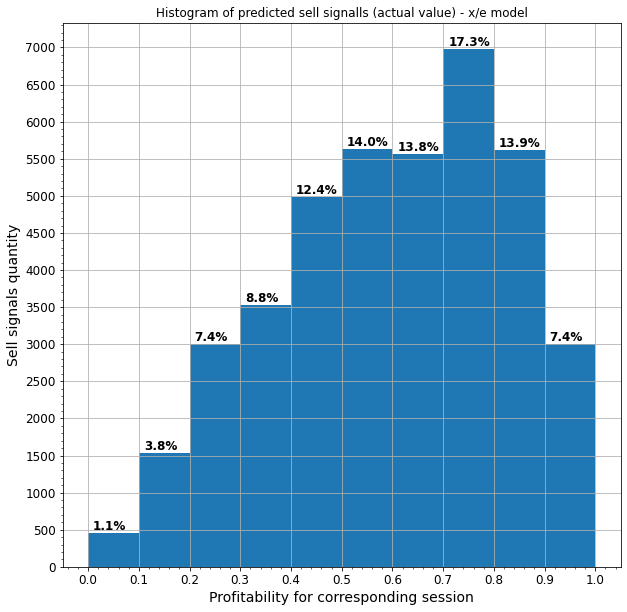

In [22]:
plt.figure(figsize=(10,10))
n, bins, _ = plt.hist(y_test_org[ids], bins=10, range=(0, 1), histtype='bar')
plt.title('Histogram of predicted sell signalls (actual value) - x/e model')
plt.xlabel('Profitability for corresponding session')
plt.ylabel('Sell signals quantity')
plt.xticks(np.arange(0,1.1,0.1))
plt.yticks(np.arange(0, 7100, 500))
plt.minorticks_on()
total_samples = len(y_test_org[ids])
for samples_qty, rectangle in zip(n, _):
    xy = (rectangle.xy[0] + 0.01, rectangle.get_height() + 40)
    perc = round((samples_qty/total_samples) * 100, 1)
    plt.annotate(f'{perc}%', xy, fontweight='bold', size='large')
plt.grid()
plt.show()

In [23]:
predicted_y_test_org = y_test_org[ids]
min, max, mean = np.min(predicted_y_test_org), np.max(predicted_y_test_org), np.mean(predicted_y_test_org)
median, scores_range, std = np.median(predicted_y_test_org), max-min, np.std(predicted_y_test_org)

statistics = {
    "Min": min,
    "Max": max,
    "Mean": mean,
    "Median": median,
    "Range": scores_range,
    "Standard deviation": std
}
statistics

{'Min': 0.0,
 'Max': 1.0,
 'Mean': 0.5969061928694263,
 'Median': 0.6176325726481715,
 'Range': 1.0,
 'Standard deviation': 0.22452150165291013}